# LLM setup

In [46]:
# Gemini LLM
from langchain.chat_models import init_chat_model
import os
from dotenv import load_dotenv
load_dotenv()


os.environ.get("GOOGLE_API_KEY")
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")



In [47]:
# tools for agent
from langchain.tools import DuckDuckGoSearchResults

web_search = DuckDuckGoSearchResults(
    max_results=3,
)

In [48]:
tools = [web_search]

llm_with_tools = llm.bind_tools(tools)

# Agent Set up

In [49]:
from typing import Annotated, Literal
from langgraph.prebuilt import ToolNode
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.types import Command 



In [50]:
# State init

class ChildState(TypedDict):
    messages: Annotated[list, add_messages]
    # decision: Literal["research", "summarize"]


In [51]:

def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

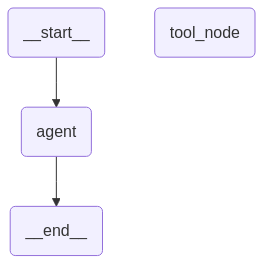

In [52]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [53]:
response=search_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})
print(response["messages"][-1].content)

The weather in Chennai is partly cloudy with a maximum temperature of 37 degrees Celsius and a minimum of 29 degrees Celsius. Rain is expected from May 5 (Monday).


# Supervisor

In [ ]:
from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool
from langchain_community.tools import DuckDuckGoSearchResults


load_dotenv()
# tools for agent


os.environ.get("GOOGLE_API_KEY")
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

web_search = DuckDuckGoSearchResults(
    max_results=3,
)


python_repl_tool = PythonREPLTool()

In [55]:
class TaskSummarizer(BaseModel):
    next: Literal["supervisor"] = Field(
        description="Based on the user's input, summarize the task"
                    "Provide an action plan using Chain of Thought reasoning"
                    "and provide a list of steps to complete the task."
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )    


def task_summarizer(state: MessagesState)-> Command[Literal["supervisor"]]:
    system_prompt = """
    You are a task summarizer.
    Based on the user's input, summarize the task.
    Provide an action plan using Chain of Thought reasoning
    and provide a list of steps to complete the task.
    Return only one of the following values for `next`:
        - 'supervisor'

        Respond using structured output only — do not explain anything outside of the `reason` field.
    """
    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"] 

    response = llm.with_structured_output(TaskSummarizer).invoke(messages)

    goto = response.next
    reason = response.reason

    # print(f"--- Workflow Transition: tasl_summarizer → {goto.upper()} ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="task_summarizer"),
            ]
        },
        goto=goto,  
    )

In [56]:
class Supervisor(BaseModel):
    next: Literal["researcher", "coder"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
                    "'researcher' when additional facts, context, or data collection is necessary, "
                    "'coder' when implementation, computation, or technical problem-solving is required."
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )

def supervisor_node(state: MessagesState) -> Command[Literal["researcher", "coder"]]:

    system_prompt = ('''
                 
        You are a workflow supervisor managing a team of three specialized agents: Researcher, and Coder. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Researcher**: Specializes in information gathering, fact-finding, and collecting relevant data needed to address the user's request.
        2. **Coder**: Focuses on technical implementation, calculations, data analysis, algorithm development, and coding solutions.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
                 
    ''')
    
    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"] 

    response = llm.with_structured_output(Supervisor).invoke(messages)

    goto = response.next
    reason = response.reason

    # print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,  
    )

In [57]:
# def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:

#     """
#         Enhancer agent node that improves and clarifies user queries.
#         Takes the original user input and transforms it into a more precise,
#         actionable request before passing it to the supervisor.
#     """
   
#     system_prompt = (
#         "You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n"
#         "1. Analyzing the original query to identify key intent and requirements\n"
#         "2. Resolving any ambiguities without requesting additional user input\n"
#         "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
#         "4. Restructuring the query for clarity and actionability\n"
#         "5. Ensuring all technical terminology is properly defined in context\n\n"
#         "Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible."
#     )

#     messages = [
#         {"role": "system", "content": system_prompt},  
#     ] + state["messages"]  

#     enhanced_query = llm.invoke(messages)

#     print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

#     return Command(
#         update={
#             "messages": [  
#                 HumanMessage(
#                     content=enhanced_query.content, 
#                     name="enhancer"  
#                 )
#             ]
#         },
#         goto="supervisor", 
#     )

In [58]:
def research_node(state: MessagesState):

    """
        Research agent node that gathers information using Tavily search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """
    
    research_agent = create_react_agent(
        llm,  
        tools=[web_search],  
        state_modifier= "You are an Information Specialist with expertise in comprehensive research. Your responsibilities include:\n\n"
            "1. Identifying key information needs based on the query context\n"
            "2. You must use search web tool to gathering relevant, accurate, and up-to-date information from reliable sources\n"
            "3. You must give the final result to answer user question by organizing findings in a structured, easily digestible format\n"
            "4. Citing sources when possible to establish credibility\n"
            "5. Focusing exclusively on information gathering - avoid analysis or implementation\n\n"
            "Provide thorough, factual responses without speculation where information is unavailable."
    )

    result = research_agent.invoke(state)

    # print(f"--- Workflow Transition: Researcher → end ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="researcher"  
                )
            ]
        },
        goto=END, 
    )

In [59]:
def code_node(state: MessagesState):

    code_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],
        state_modifier=(
            "You are a coder and analyst. Focus on mathematical calculations, analyzing, solving math questions, "
            "and executing code. Handle technical problem-solving and data tasks."
        )
    )

    result = code_agent.invoke(state)

    # print(f"--- Workflow Transition: Coder → end ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto=END,
    )

In [60]:
# # System prompt providing clear instructions to the validator agent
# system_prompt = '''
#     Your task is to ensure reasonable quality. 
#     Specifically, you must:
#     - Review the user's question (the first message in the workflow).
#     - Review the answer (the last message in the workflow).
#     - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
#     - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
    
#     - Accept answers that are "good enough" rather than perfect
#     - Prioritize workflow completion over perfect responses
#     - Give benefit of doubt to borderline answers
    
#     Routing Guidelines:
#     1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
#     2. Respond with 'FINISH' in all other cases to end the workflow.
# '''

# class Validator(BaseModel):
#     next: Literal["supervisor", "FINISH"] = Field(
#         description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
#     )
#     reason: str = Field(
#         description="The reason for the decision."
#     )

# def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

#     user_question = state["messages"][0].content
#     agent_answer = state["messages"][-1].content

#     messages = [
#         {"role": "system", "content": system_prompt},
#         {"role": "user", "content": user_question},
#         {"role": "assistant", "content": agent_answer},
#     ]

#     response = llm.with_structured_output(Validator).invoke(messages)

#     goto = response.next
#     reason = response.reason

#     if goto == "FINISH" or goto == END:
#         goto = END  
#         print(" --- Transitioning to END ---")  
#     else:
#         print(f"--- Workflow Transition: Validator → Supervisor ---")
 

#     return Command(
#         update={
#             "messages": [
#                 HumanMessage(content=reason, name="validator")
#             ]
#         },
#         goto=goto, 
#     )

In [61]:
graph = StateGraph(MessagesState)

graph.add_node("task_summarizer", task_summarizer)
graph.add_node("supervisor", supervisor_node) 
# graph.add_node("enhancer", enhancer_node)  
graph.add_node("researcher", research_node) 
graph.add_node("coder", code_node) 
# graph.add_node("validator", validator_node)  

graph.add_edge(START, "task_summarizer")  
app = graph.compile()

In [62]:
# from IPython.display import display, Image

# display(Image(app.get_graph().draw_mermaid_png()))

In [63]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [64]:
inputs = {
    "messages": [
        ("user", "Weather in Chennai"),
    ]
}

for event in app.stream(inputs):
    pretty_print_messages(event)
     

Update from node task_summarizer:


================================ Human Message =================================
Name: task_summarizer

The user is asking for the weather in Chennai. This requires me to route the request to a specialist, specifically a weather expert, to fetch the weather information for the specified location. The next step is to involve the 'supervisor' to find the weather expert..


Update from node supervisor:


================================ Human Message =================================
Name: supervisor

The user is asking a question that requires gathering information. The researcher is best suited to find the weather information for Chennai. 


Update from node researcher:


================================ Human Message =================================
Name: researcher

The weather forecast for Chennai indicates partly cloudy skies with a maximum temperature of 37 degrees Celsius and a minimum of 29 degrees Celsius. Rainfall is expected from May 5 (Mon

In [65]:
input = {
    "messages": ["Give me the 20th fibonacci number"]
}


events = app.astream_events(input=input, version="v2")

async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)



The 20th Fibonacci number is 6765.


In [67]:
input = {
    "messages": ["Hi, research about Donal Trump in 2025"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

Based on the search results, here's what I found regarding Donald Trump in 2025:

*   **Second Presidency:** Some sources refer to a timeline of Donald Trump's second presidency, starting with his inauguration on January 20, 2025.
*   **First 100 Days:** Reports mention Trump securing trillions in new U.S.-based investments and job creation within his first 100 days.
*   **Project 2025:** This is a policy plan from the Heritage Foundation that aligns with many of Trump's policies during his second term, focusing on expanding presidential power and conservative social visions.
*   **News Events:** News articles from CNN and other sources detail specific events during his presidency in 2025, such as executive orders and reactions to his dialogues with other world leaders.

